<a href="https://colab.research.google.com/github/urieliram/analog/blob/main/Aplicaci%C3%B3n_de_RNN_y_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este ejercicio, haremos un pronóstico multivariado a múltiples pasos utilizando una red recurrente LSTM apilada. Se utilizará transfer learning para reusar el modelo construído con datos anteriores para obtener un modelo para un período dado.

# Pronóstico multivariado a múltiples pasos con redes LSTM

In [1]:
# Redes neuronales
import torch
from   torch import nn
from   torch.utils.data import Dataset, DataLoader

# Utilidades numéricas
import numpy as np
import pandas as pd

# Graficación
import matplotlib.pyplot as plt
import seaborn as sns

# Utilidades - aprendizaje automático
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Utilidades - barras de carga
from tqdm.auto import tqdm

# montamos la unidad de drive en colab
from google.colab import drive

## Cargar datos, Preprocesamiento e Ingeniería de características

In [2]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path = 'https://drive.google.com/uc?export=download&id=' 
URL  = 'https://drive.google.com/file/d/1057_dPk6rIZgXVku8kmZjq3m8WQNkJZb/view?usp=sharing'
df = pd.read_csv(path+URL.split('/')[-2],usecols=[0,1,2,3,4,5,6,7],names=['Date','SERIE1','SERIE2','SERIE3','SERIE4','SERIE5','SERIE6','SERIE7'],
                 dtype={'Date':str,'SERIE1':float,'SERIE2':float,'SERIE3':float,'SERIE4':float,'SERIE5':float,'SERIE6':float,'SERIE7':float}) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,]
df.dropna(inplace=True)

In [3]:
df['Date'] = pd.to_datetime(df['Date'],format= '%d-%m-%Y %H:%M' ) #.dt.date https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.date.html
df   = df.set_index('Date')
df_5 = df.resample('5T').mean()
df_5.head()
df   = df_5

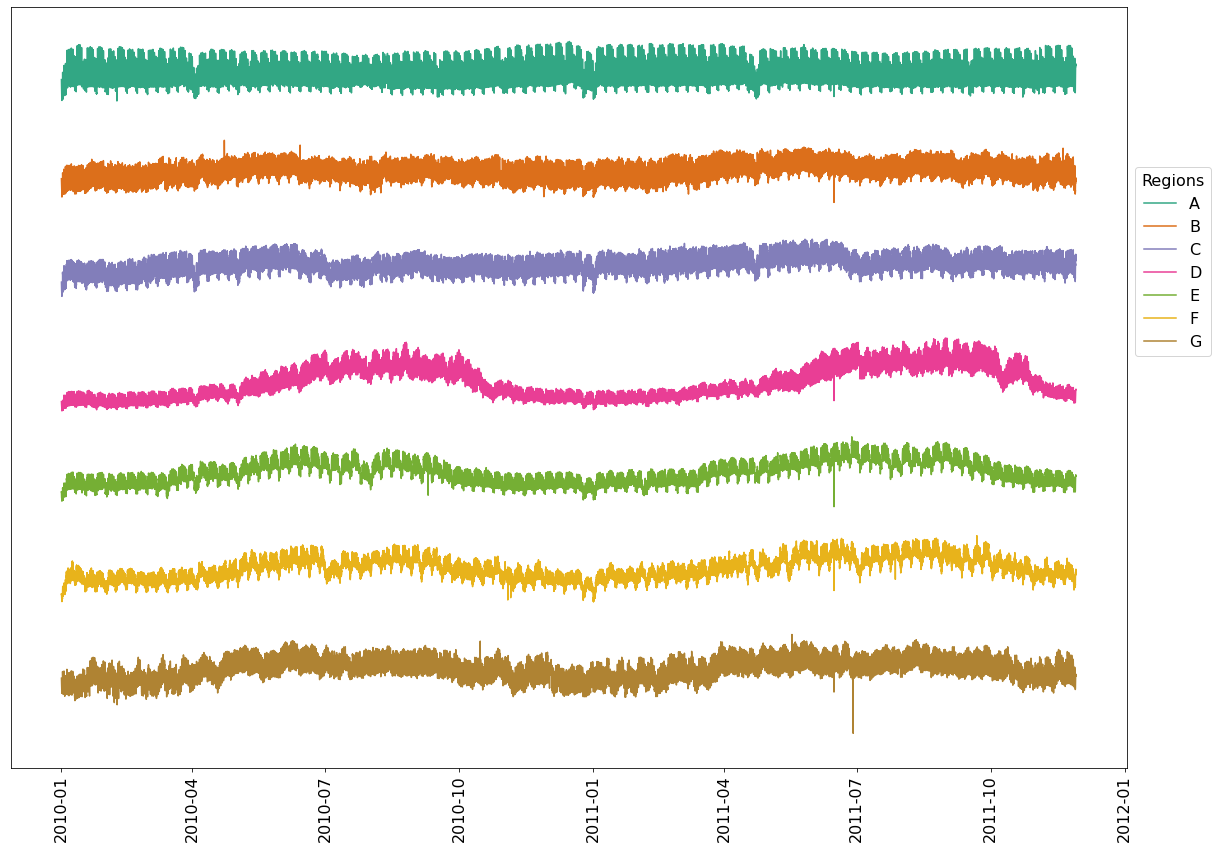

In [4]:
regions = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
if  True:
  i = 0
  j = 0
  cmap = plt.cm.Dark2 #tab20 https://matplotlib.org/stable/gallery/color/colormap_reference.html
  fig, ax = plt.subplots(figsize=(20,14))
  for ts in df_5:
    max_t = df_5[ts].max()
    plt.plot(df_5[ts].index, df_5[ts] / max_t + j, c = cmap(i), label=regions[i], alpha=.9)
    i += 1
    j -= 1
  plt.yticks([])
  plt.xticks(rotation=90, fontsize=16)
  plt.legend(bbox_to_anchor=(1, 0.8), prop={'size': 16}, title="Regions", title_fontsize=16)
  plt.savefig('series.pdf')
  plt.show()

In [5]:
## Convertir a tipo de dato de fecha
df.reset_index(inplace=True)  ## Covert Index to Column.
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

# Convertir a valores numéricos
dtypes = {col:'float' for col in df.columns[1:]}
df = df.astype(dtypes)

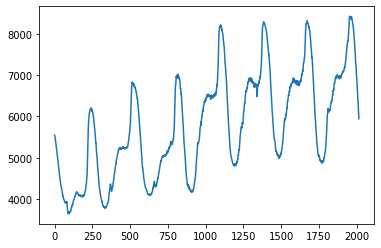

In [6]:
plt.plot(df['SERIE1'][0:288*7])

Extraer información de día de la semana, mes y hora a partir de la fecha

In [7]:
df['day_of_week'] = df.Date.dt.dayofweek
df['month'      ] = df.Date.dt.month
df['hour'       ] = df.Date.dt.hour
df['minute'     ] = df.Date.dt.minute

Preprocesamiento general

In [8]:
# Indexar por fecha
df.set_index('Date', inplace=True)

# # Renombrar columnas
# rename_cols = {
#   'Load (kW)': 'load',
#   'Pressure_kpa': 'pressure',
#   'Cloud Cover (%)': 'cloud_cover',
#   'Humidity (%)': 'humidity',
#   'Temperature (C) ': 'temperature',
#   'Wind Speed (kmh)': 'wind_speed',
# }

# df.rename(columns=rename_cols, inplace=True)

# cols = [
#   'load',
#   'pressure',
#   'cloud_cover',
#   'humidity',
#   'temperature',
#   'wind_speed',
#   'day_of_week',
#   'month',
#   'hour',
#   'wind_dir_sin',
#   'wind_dir_cos'
# ]

cols = [
  'SERIE1',
  'day_of_week',
  'month',
  'hour',
  'minute',
]

df = df[cols]

In [9]:
df

,SERIE1,day_of_week,month,hour,minute
Date,,,,,
2010-01-01 00:00:00,5547.831152,4,1,0,0
2010-01-01 00:05:00,5535.618164,4,1,0,5
2010-01-01 00:10:00,5529.010351,4,1,0,10
2010-01-01 00:15:00,5514.982032,4,1,0,15
2010-01-01 00:20:00,5472.567285,4,1,0,20
...,...,...,...,...,...
2011-11-28 15:30:00,6916.361426,0,11,15,30
2011-11-28 15:35:00,6941.604590,0,11,15,35
2011-11-28 15:40:00,6933.826563,0,11,15,40


## Exploración de los datos

La variable de interés es `load` que corresponde al consumo energético.

Graficamos esta variable para observar qué patrones tiene.

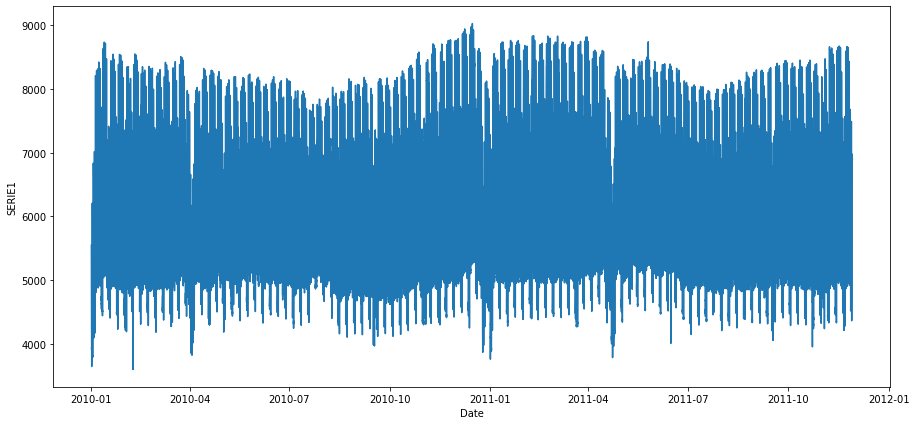

In [23]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=df, y='SERIE1' ,x='Date')#,, y='SERIE1' x='Date'
plt.show()

Analizaremos cada segmento de la serie por separado.

Entrenaremos un primer modelo predictivo para el comportamiento antes de la cuarentena. Posteriormente, usando transferencia de aprendizaje, partiremos de este primer modelo para hacer uno entrenado para predecir el energético durante la cuarentena.

In [24]:
# Dividr datos antes y después 
# bc: before ; ac: after 
data_bc = df.loc[:'2010-06-1']
data_ac = df.loc['2010-06-1':]
print('Data before:', len(data_bc), sep='\t')
print('Data after:', len(data_ac), sep='\t')

Data before:	43776
Data after:	157151


## Predicción de consumo energético previo a la cuarentena

### Procesamiento de datos para entrenamiento

Dividimos los datos en dos conjuntos, entrenamiento y validación

In [25]:
train_data, test_data = train_test_split(data_bc, train_size=0.8, shuffle=False)
print('Training data:', len(train_data), sep='\t\t')
print('Validation data:', len(test_data), sep='\t')

Training data:		35020
Validation data:	8756


Normalizamos los datos. Nótese que el normalizador se calcula con los datos de entrenamiento para evitar que se filtre información del conjunto de datos de validación al de entrenamiento.

In [26]:
# Normalizar datos
scaler = MinMaxScaler(feature_range=(0, 1))

# Obtener parámetros para normalizar de los datos de entrenamiento
train_data_normalized = scaler.fit_transform(train_data)

# Normalizar con los mismos parámetros a los datos de validación
test_data_normalized = scaler.transform(test_data)

Creamos una clase para cargar los datos al modelo

In [27]:
class TimeseriesDataset(torch.utils.data.Dataset):
  """ Clase para crear conjuntos de datos para series de tiempo

      Dada una serie de tiempo (posiblemente multivariada),
      crea conjuntos de datos de entrada y salida según un tamaño de ventana
      y un horizonte de predicción
  """

  def __init__(self, X, y, window, horizon):
    self.X = X
    self.y = y
    self.window = window
    self.horizon = horizon

  def __len__(self):
    return self.X.__len__() - self.horizon - self.window

  def __getitem__(self, index):
    return (
      self.X[index:index + self.window],
      self.y[index + self.window: index + self.window + self.horizon]
    )

Creamos el cargador de datos

In [28]:
# Valores previos para predicción: 1 semana de valores horarios
window = 288 * 7 #24 * 7

# Horizonte de predicción: 1 día con valores horarios
horizon = 288 #24

# Ejemplos a considerar por paso de entrenamiento
batch_size = 30 #16

train_dataset = TimeseriesDataset(train_data_normalized, train_data_normalized[:, 0], window, horizon)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TimeseriesDataset(test_data_normalized, test_data_normalized[:, 0], window, horizon)
test_loader = torch.utils.data.DataLoader(test_dataset)

## Modelado

El modelo es una red neuronal recurrente compuesta por dos capas de unidades LSTM seguidas por una capa densa.

In [29]:
class LSTM(nn.Module):
  def __init__(self, n_features, n_hidden, n_layers):
    super().__init__()
    self.n_hidden = n_hidden
    self.n_layers = n_layers

    # Capa LSTM
    self.l_lstm = nn.LSTM(input_size=n_features, 
                          hidden_size=self.n_hidden,
                          num_layers=self.n_layers, 
                          batch_first=True)
  
    # Capa Densa de activación lineal
    self.l_linear = nn.Linear(self.n_hidden * window, horizon)

    # Estado escondido
    self.hidden_cell = (torch.zeros(1,1,self.n_hidden),) * n_hidden

  def init_hidden(self, batch_size):
    hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
    cell_state   = torch.zeros(self.n_layers,batch_size,self.n_hidden)
    self.hidden  = (hidden_state, cell_state)

  def forward(self, x):
    batch_size, seq_len, _ = x.size()
    lstm_out, self.hidden  = self.l_lstm(x,self.hidden)
    x = lstm_out.contiguous().view(batch_size,-1)
    return self.l_linear(x)

Determinamos los hiperparámetros de la red.

A mayor número de capas (`n_layers`) la red tendrá capacidad de encontrar patrones de mayor abstracción.

A mayor cantidad de celdas ocultas (`n_hidden`) la red tendrá más capacidad para ajustarse a los datos.

Los mejores valores para cada hiperparámetro dependerán del problema. Para encontrar los óptimos se puede aplicar optimización de hiperparámetros.

In [35]:
# Hiperparámetros de la red
n_features = len(cols) #cols
n_hidden = 1 #200
n_layers = 1 #2

In [37]:
n_features


5

Instanciamos la red y el optimizador. Utilizaremos el error cuadrático medio (MSE) como función de pérdida.

In [38]:
model = LSTM(n_features, n_hidden, n_layers)
loss_function = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [39]:
print(model)

LSTM(
  (l_lstm): LSTM(5, 1, batch_first=True)
  (l_linear): Linear(in_features=2016, out_features=288, bias=True)
)


Entrenamos por 5 épocas. Es decir, se ajustará el modelo a los datos de entrenamiento haciendo 5 pasados sobre todo el conjunto.

En cada época se imprime el error de entrenamiento y de validación.

In [40]:
epochs = 5

for i in range(epochs):
  print('Epoch:', i + 1)

  # Train
  print('Train')
  model.train(True)
  for inpt, target in tqdm(train_loader):
    model.init_hidden(inpt.size(0))
    output = model(inpt.float()) 
    loss = loss_function(output, target.float())
    loss.backward()
    optimizer.step()  
    optimizer.zero_grad() 
  print('Train loss :', loss.item())

  # Test
  print('\nTest')
  model.train(False)
  running_loss = 0
  for inpt, target in tqdm(test_loader):
    model.init_hidden(inpt.size(0))
    output = model(inpt.float()) 
    running_loss += loss_function(output, target.float()).item()

  print('Test loss :', running_loss / len(test_loader))
  print()


Epoch: 1
Train


  0%|          | 0/1091 [00:00<?, ?it/s]

Train loss : 0.02630206197500229

Test


  0%|          | 0/6452 [00:00<?, ?it/s]

Test loss : 0.021628994539712648

Epoch: 2
Train


  0%|          | 0/1091 [00:00<?, ?it/s]

Train loss : 0.012633043341338634

Test


  0%|          | 0/6452 [00:00<?, ?it/s]

Test loss : 0.012045183601677742

Epoch: 3
Train


  0%|          | 0/1091 [00:00<?, ?it/s]

Train loss : 0.011757799424231052

Test


  0%|          | 0/6452 [00:00<?, ?it/s]

Test loss : 0.008585899703411625

Epoch: 4
Train


  0%|          | 0/1091 [00:00<?, ?it/s]

Train loss : 0.004990632180124521

Test


  0%|          | 0/6452 [00:00<?, ?it/s]

Test loss : 0.00728751104179988

Epoch: 5
Train


  0%|          | 0/1091 [00:00<?, ?it/s]

Train loss : 0.003619869938120246

Test


  0%|          | 0/6452 [00:00<?, ?it/s]

Test loss : 0.006849316643288715



In [44]:
model.train(False)

LSTM(
  (l_lstm): LSTM(5, 1, batch_first=True)
  (l_linear): Linear(in_features=2016, out_features=288, bias=True)
)

In [53]:
def plot_past_future(X, y):
  ex_input = torch.Tensor(X)

  unscaled_past = scaler.inverse_transform(ex_input)[:, 0]

  ex_input = ex_input.unsqueeze(0)

  model.init_hidden(ex_input.size(0))
  ex_output = model(ex_input)
  day = 288    ##24
  aux = 144    #11 
  ex_output_array = np.zeros((day, aux))
  ex_output_array[:, 0] = ex_output.detach().numpy()
  unscaled_output = scaler.inverse_transform(ex_output_array)[:, 0]

  real_future = np.zeros((day, aux))
  real_future[:, 0] = y
  unscaled_future = scaler.inverse_transform(real_future)[:, 0]

  plt.figure(figsize=(10, 5))

  plt.plot(np.arange(-window, 0), unscaled_past, label='past')

  plt.plot(np.arange(horizon), unscaled_future, label='real')
  plt.plot(np.arange(horizon), unscaled_output, '.', label='prediction')
  plt.legend(loc="lower left")
  plt.show()

Tomamos una muestra del conjunto de validación para observar cómo se ven las predicciones del modelo

In [54]:
for _ in range(30): #10
  example = test_dataset[np.random.randint(len(test_dataset))]
  plot_past_future(*example)

ValueError: ignored

Graficamos todas las predicciones en el conjunto de datos de validación para observar el comportamiento general del modelo

  0%|          | 0/6452 [00:00<?, ?it/s]

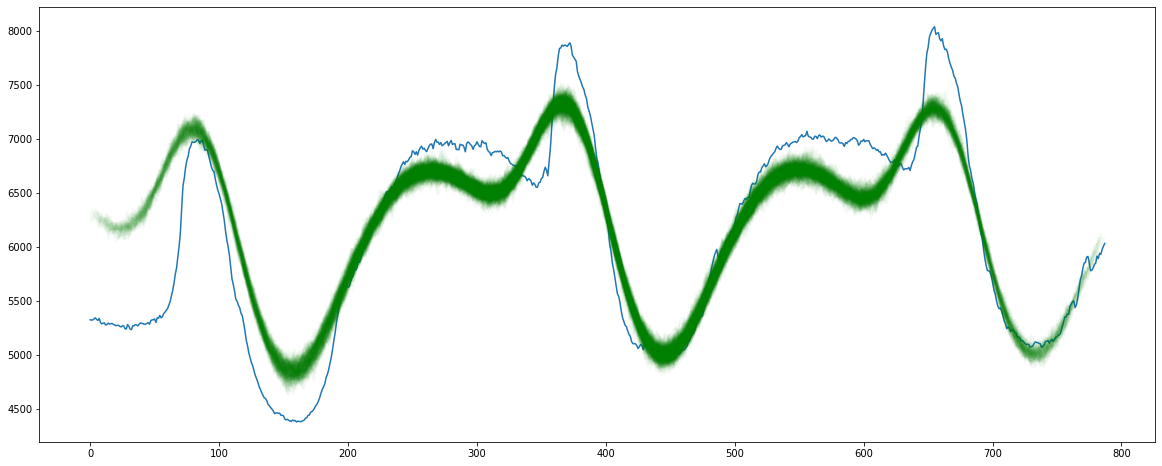

Validation MAE: 451.4731889794371
Validation MAPE: 0.07790046925943486


In [55]:
total_mae = 0
total_mape = 0

n = 500
# n = len(test_dataset)
plt.figure(figsize=(20, 8))
plt.plot(test_data.to_numpy()[:n + horizon, 0])

for i, (inpt, target) in enumerate(tqdm(test_loader)):
  if i > n:
    break
  unscaled_past = scaler.inverse_transform(inpt[0, :, :])[:, 0]

  model.init_hidden(inpt.size(0))
  output = model(inpt.float()) 
  
  output_array = np.zeros((horizon, n_features))
  output_array[:, 0] = output.detach().numpy()
  unscaled_output = scaler.inverse_transform(output_array)[:, 0]

  real_future = np.zeros((horizon, n_features))
  real_future[:, 0] = target
  unscaled_future = scaler.inverse_transform(real_future)[:, 0]

  plt.plot(np.arange(i, i + horizon), unscaled_output, alpha=0.04, color='green')

  mae = np.absolute(unscaled_output - unscaled_future)
  mae = np.sum(mae)
  total_mae += mae

  mape = np.absolute((unscaled_output - unscaled_future) / unscaled_future)
  mape = np.sum(mape)
  total_mape += mape

plt.show()

total_mae /= n * horizon
total_mape /= n * horizon

print('Validation MAE:', total_mae)
print('Validation MAPE:', total_mape)

In [ ]:
total_mae = 0
total_mape = 0

# n = 500
n = len(test_dataset)
plt.figure(figsize=(20, 8))
plt.plot(test_data.to_numpy()[:n + horizon, 0])

for i, (inpt, target) in enumerate(tqdm(test_loader)):
  if i > n:
    break
  unscaled_past = scaler.inverse_transform(inpt[0, :, :])[:, 0]

  model.init_hidden(inpt.size(0))
  output = model(inpt.float()) 
  
  output_array = np.zeros((horizon, n_features))
  output_array[:, 0] = output.detach().numpy()
  unscaled_output = scaler.inverse_transform(output_array)[:, 0]

  real_future = np.zeros((horizon, n_features))
  real_future[:, 0] = target
  unscaled_future = scaler.inverse_transform(real_future)[:, 0]

  plt.plot(np.arange(i, i + horizon), unscaled_output, alpha=0.04, color='green')

  mae = np.absolute(unscaled_output - unscaled_future)
  mae = np.sum(mae)
  total_mae += mae

  mape = np.absolute((unscaled_output - unscaled_future) / unscaled_future)
  mape = np.sum(mape)
  total_mape += mape

plt.show()

total_mae /= n * horizon
total_mape /= n * horizon

print('Validation MAE:', total_mae)
print('Validation MAPE:', total_mape)

## Transferencia de aprendizaje para el comportamiento posterior al inicio de la cuarentena

No contamos con muchos datos sobre el consumo de energía durante la cuarentena, por lo tanto no es factible entrenar un modelo directamente con estos datos.

A la vez, el cambio en la dinámica previo y durante la cuarentena es muy drástico y un modelo entrenado con todos los datos muy probablemente tendría problemas para ajustarse correctamente.

Por ello optamos por aplicar transferencia de aprendizaje. Esta técnica consta de partir de un modelo entrenado en una tarea y ajustarlo a una tarea distinta pero lo suficientemente similar para esperar que el modelo pueda generalizar correctamente. De esta forma podemos aprovechar todos los datos.

In [56]:
print('Data before:', len(data_bc), sep='\t')
print('Data after:', len(data_ac), sep='\t')

Data before:	43776
Data after:	157151


Normalizamos los datos con el mismo escalador

In [57]:
# Usar el mismo escalador
data_ac_normalized = scaler.transform(data_ac)

In [58]:
def train_model(model, train_loader, epochs=3, lr=0.00001):
  loss_function = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  model.train(True)

  for i in range(epochs):
    print('Epoch:', i + 1)

    # Train
    print('Train')
    for inpt, target in tqdm(train_loader):
      model.init_hidden(inpt.size(0))
      output = model(inpt.float()) 
      loss = loss_function(output, target.float())
      loss.backward()
      optimizer.step()  
      optimizer.zero_grad() 
    print('Train loss :', loss.item())
    print()
  model.train(False)

  return loss_function

In [59]:
def eval_model(model, test_loader, loss_function, scaler):
  agg_preds = np.empty(len(test_loader))
  print(len(test_loader))
  preds = []
  futures = []

  running_loss = 0

  for i, (inpt, target) in enumerate(tqdm(test_loader)):
    unscaled_past = scaler.inverse_transform(inpt[0, :, :])[:, 0]

    model.init_hidden(inpt.size(0))
    output = model(inpt.float())
    running_loss += loss_function(output, target.float()).item()
    
    output_array = np.zeros((horizon, n_features))
    output_array[:, 0] = output.detach().numpy()
    unscaled_output = scaler.inverse_transform(output_array)[:, 0]

    real_future = np.zeros((horizon, n_features))
    real_future[:, 0] = target
    unscaled_future = scaler.inverse_transform(real_future)[:, 0]

    preds.append(unscaled_output)
    futures.append(unscaled_future)
  
  print('Test loss :', running_loss / len(test_loader))

  return preds, futures
    

Una forma de evaluar el poder de generalización del modelo es utilizando validación cruzada.

Para series de tiempo la validación cruzada consiste en dividir los datos en $k$ dobleces. Se parte de un determinado número de dobleces iniciales para entrenar a un modelo y se evalúa en el doblez siguiente. En cada iteración posterior se agrega un nuevo doblez para el entrenamiento y nuevamente se valida en el doblez siguiente.

Al final todos los resultados de validación son agregados.

In [ ]:
k_folds = 10
start_folds = 2
cv_preds = dict()
n_transfer_data = len(data_ac_normalized)
n_fold_data = n_transfer_data // k_folds


for i in range(start_folds, k_folds):
  print(list(range(i)), i)
  n_train_data = i * n_fold_data
  train_data = data_ac_normalized[:n_train_data]
  test_data = data_ac_normalized[n_train_data:n_train_data + n_fold_data]

  train_dataset = TimeseriesDataset(train_data, train_data[:, 0], window, horizon)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  test_dataset = TimeseriesDataset(test_data, test_data[:, 0], window, horizon)
  test_loader = torch.utils.data.DataLoader(test_dataset)

  # Clonar modelo base
  model_i = LSTM(n_features, n_hidden, n_layers)
  model_i.load_state_dict(model.state_dict())

  loss_function = train_model(model_i, train_loader)
  preds, futures = eval_model(model_i, test_loader, loss_function, scaler)
  cv_preds[i] = (preds, futures)


[0, 1] 2
Epoch: 1
Train


  0%|          | 0/971 [00:00<?, ?it/s]

Train loss : 0.009484204463660717

Epoch: 2
Train


  0%|          | 0/971 [00:00<?, ?it/s]

Train loss : 0.006613530684262514

Epoch: 3
Train


  0%|          | 0/971 [00:00<?, ?it/s]

Train loss : 0.0035966753493994474

13411


  0%|          | 0/13411 [00:00<?, ?it/s]

Test loss : 0.011721499753156839
[0, 1, 2] 3
Epoch: 1
Train


  0%|          | 0/1495 [00:00<?, ?it/s]

Train loss : 0.006497994996607304

Epoch: 2
Train


  0%|          | 0/1495 [00:00<?, ?it/s]

Train loss : 0.00870988517999649

Epoch: 3
Train


  0%|          | 0/1495 [00:00<?, ?it/s]

Train loss : 0.00703084422275424

13411


  0%|          | 0/13411 [00:00<?, ?it/s]

Test loss : 0.019844807888276392
[0, 1, 2, 3] 4
Epoch: 1
Train


  0%|          | 0/2019 [00:00<?, ?it/s]

Analizando el error en cada doblez podemos darnos una idea de qué tan dependiente es el modelo al número de datos disponibles de entrenamiento.

Podemos esperar que conforme se agregan más dobleces el error de validación disminuirá. A la vez, si hay más cambios en el comportamiento veremos que el error aumente.

In [ ]:
n = 0
total_mae = 0
total_mape = 0

plt.figure(figsize=(20, 10))
plt.plot(data_ac.to_numpy()[:,0])

start_preds = start_folds * n_fold_data
for fold, (preds, futures) in cv_preds.items():
  for i, (pred, future) in enumerate(zip(preds, futures)):
    start_range = start_preds + (fold - start_folds) * n_fold_data
    x = np.arange(start_range + i, start_range + i + horizon)
    plt.plot(x, pred, alpha=0.2, color='green')

    mae = np.absolute(pred - future)
    mae = np.sum(mae)
    total_mae += mae

    mape = np.absolute((pred - future) / future)
    mape = np.sum(mape)
    total_mape += mape

    n += len(pred)

  print(f'Validation MAE upto fold {fold}:', total_mae / n)
  print(f'Validation MAPE upto fold {fold}:', total_mape / n)
  print()
  
total_mae /= n
total_mape /= n

print('Validation MAE:', total_mae)
print('Validation MAPE:', total_mape)